In [4]:
import os
import json
import glob
import numpy as np
import hashlib
from urllib.parse import urlparse
from collections import Counter, defaultdict
from warcio.archiveiterator import ArchiveIterator
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk

In [ ]:
nltk.download('punkt')  # Download tokenization resources
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/gabriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
JSONL_PATH = "../backup/log.jsonl"
WARC_FOLDER = "corpus"

In [ ]:
domain_counter = Counter()
page_sizes_bytes = []
page_token_counts = []
fetch_timestamps = []

In [ ]:
def get_domain(url):
    try:
        parsed = urlparse(url)
        return parsed.netloc.lower()
    except Exception:
        return None

def clean_html(raw_html):
    import re
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [14]:
print("Analyzing JSONL metadata...")

with open(JSONL_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            data = json.loads(line)
            url = data.get('URL')
            timestamp = data.get('Timestamp')
            if url and timestamp:
                domain = get_domain(url)
                if domain:
                    domain_counter[domain] += 1
                fetch_timestamps.append(timestamp)
        except json.JSONDecodeError:
            continue

print(f"Found {len(domain_counter)} unique domains.")
print(f"Found {len(fetch_timestamps)} total pages.")

Analyzing JSONL metadata...
Found 1319 unique domains.
Found 100094 total pages.


In [ ]:
print("Analyzing WARC files...")

warc_files = glob.glob(os.path.join(WARC_FOLDER, "*.warc.gz"))

import random
random.seed(42)  

for warc_path in tqdm(warc_files, desc="Processing WARC files"):
  with open(warc_path, 'rb') as stream:
    for record in tqdm(ArchiveIterator(stream), desc=f"Processing records in {os.path.basename(warc_path)}", leave=False):
      if record.rec_type != 'response':
        continue

      payload = record.content_stream().read()
      html_size = len(payload)
      page_sizes_bytes.append(html_size)

      try:
        text = payload.decode('utf-8', errors='ignore')
        clean_text = clean_html(text)
        tokens = word_tokenize(clean_text)
        page_token_counts.append(len(tokens))
      except Exception:
        continue

print(f"Collected {len(page_sizes_bytes)} page sizes (bytes).")
print(f"Collected {len(page_token_counts)} page token counts.")


Analyzing WARC files...


Processing WARC files: 100%|██████████| 101/101 [25:25<00:00, 15.11s/it]

Collected 100095 page sizes (bytes).
Collected 100094 page token counts.


In [ ]:
print("Computing final metrics...")

total_time_seconds = max(fetch_timestamps) - min(fetch_timestamps)
download_rate = len(fetch_timestamps) / total_time_seconds if total_time_seconds > 0 else 0

print(f"Total crawl time (seconds): {total_time_seconds}")
print(f"Average download rate (pages/sec): {download_rate:.2f}")


Computing final metrics...
Total crawl time (seconds): 15076
Average download rate (pages/sec): 6.64


75.88627748294162


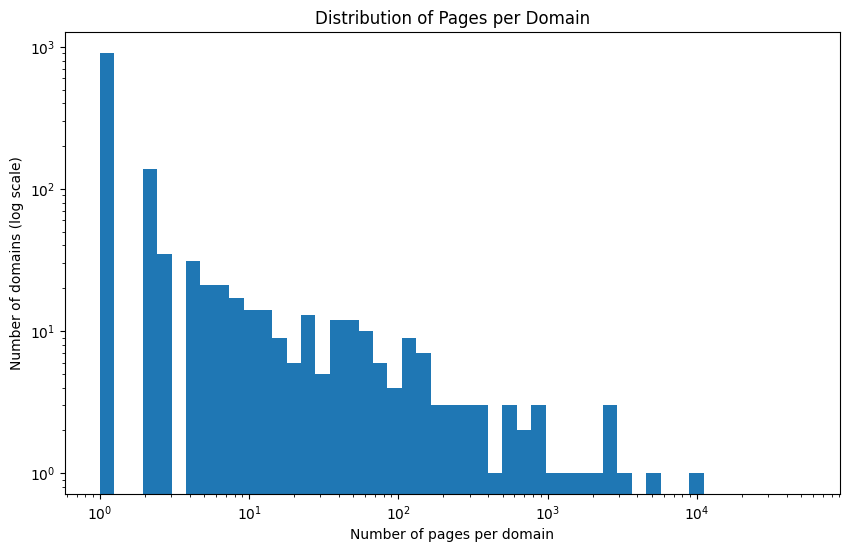

In [16]:
bins = np.logspace(np.log10(1), np.log10(max(domain_counter.values())), 50)

plt.figure(figsize=(10,6))
plt.hist(domain_counter.values(), bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of pages per domain')
plt.ylabel('Number of domains (log scale)')
plt.title('Distribution of Pages per Domain')


print(sum(domain_counter.values()) / len(domain_counter))

Text(0.5, 1.0, 'Distribution of Page Sizes (Bytes)')

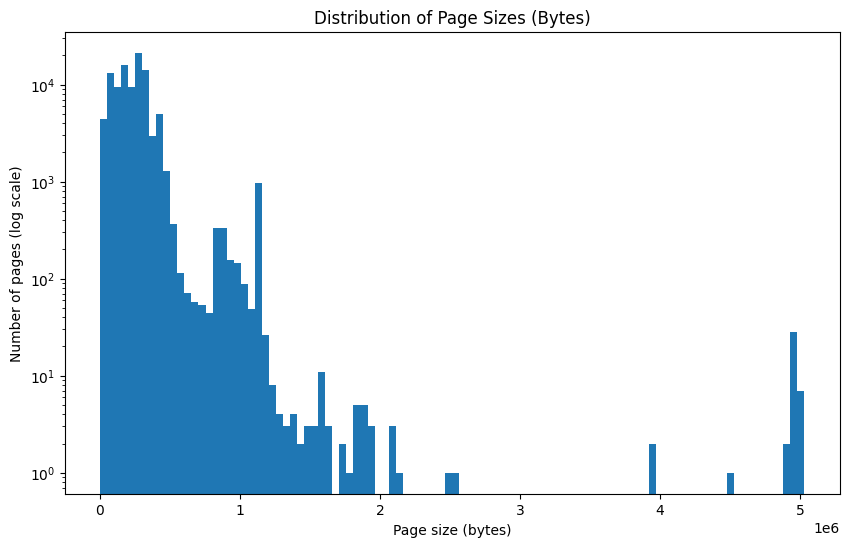

In [ ]:

plt.figure(figsize=(10,6))
plt.hist(page_sizes_bytes, bins=100, log=True)
plt.xlabel('Page size (bytes)')
plt.ylabel('Number of pages (log scale)')
plt.title('Distribution of Page Sizes (Bytes)')



In [ ]:
bins = np.logspace(np.log10(1), np.log10(max(page_token_counts)), 100)

plt.figure(figsize=(10,6))
plt.hist(page_token_counts, bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of tokens per page (log scale)')
plt.ylabel('Number of pages (log scale)')
plt.title('Distribution of Tokens per Page')
plt.show()

NameError: name 'page_token_counts' is not defined

In [ ]:
from bs4 import BeautifulSoup

out_links_per_page = []

print("Calculating the number of out-links per page...")

for warc_path in tqdm(warc_files, desc="Processing WARC files"):
  with open(warc_path, 'rb') as stream:
    for record in tqdm(ArchiveIterator(stream), desc=f"Processing records in {os.path.basename(warc_path)}", leave=False):
      if record.rec_type != 'response':
        continue

      payload = record.content_stream().read()

      try:
        html_content = payload.decode('utf-8', errors='ignore')
        soup = BeautifulSoup(html_content, 'html.parser')
        out_links = soup.find_all('a', href=True)
        out_links_per_page.append(len(out_links))
      except Exception:
        out_links_per_page.append(0)  # If parsing fails, assume 0 out-links

print(f"Collected out-links for {len(out_links_per_page)} pages.")


Calculating the number of out-links per page...


Processing WARC files:  51%|█████▏    | 52/101 [1:03:06<1:09:54, 85.60s/it]/tmp/ipykernel_119459/52036484.py:18: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(html_content, 'html.parser')
Processing WARC files: 100%|██████████| 101/101 [2:07:53<00:00, 75.97s/it] 

Collected out-links for 100094 pages.


In [ ]:
print("\n===== Summary =====")
print(f"Unique domains: {len(domain_counter)}")
print(f"Total pages: {len(fetch_timestamps)}")
print(f"Avg download rate: {download_rate:.2f} pages/sec")
print(f"Avg page size: {sum(page_sizes_bytes)/len(page_sizes_bytes):.2f} bytes")
print(f"Avg tokens per page: {sum(page_token_counts)/len(page_token_counts):.2f} tokens")
print(f"Most common domains: {domain_counter.most_common(10)}")
print(f"Avg out-links per page: {sum(out_links_per_page)/len(out_links_per_page):.2f} links")


===== Summary =====
Unique domains: 1319
Total pages: 100094
Avg download rate: 6.64 pages/sec
Avg page size: 243521.24 bytes
Avg tokens per page: 3082.45 tokens
Most common domains: [('www1.folha.uol.com.br', 52497), ('www.uol.com.br', 9030), ('brasilescola.uol.com.br', 5283), ('exercicios.brasilescola.uol.com.br', 2960), ('mundoeducacao.uol.com.br', 2544), ('escolakids.uol.com.br', 2497), ('f5.folha.uol.com.br', 2460), ('vestibular.brasilescola.uol.com.br', 1931), ('exercicios.mundoeducacao.uol.com.br', 1723), ('economia.uol.com.br', 1367)]
Avg out-links per page: 360.31 links


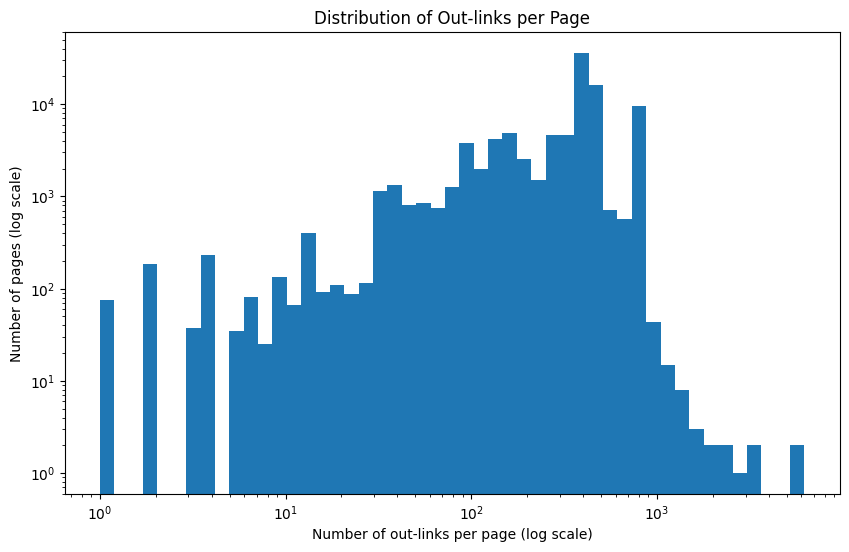

In [ ]:
# Log-spaced bins
bins = np.logspace(np.log10(1), np.log10(max(out_links_per_page)), 50)

plt.figure(figsize=(10,6))
plt.hist(out_links_per_page, bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of out-links per page (log scale)')
plt.ylabel('Number of pages (log scale)')
plt.title('Distribution of Out-links per Page')
plt.show()

In [ ]:
folders = ["./1thread", "./10threads", "./25threads", "./50threads", "./100threads", "./200threads", "./500threads"]
average_network_rates = []
for folder in folders:
  fetch_timestamps = []
  jsonl_path = os.path.join(folder, "tmp", "log.jsonl")
  if os.path.exists(jsonl_path):
    with open(jsonl_path, 'r', encoding='utf-8') as f:
      for line in tqdm(f, desc=f"Processing {jsonl_path}", leave=False):
        try:
          data = json.loads(line)
          url = data.get('URL')
          timestamp = data.get('Timestamp')
          if url and timestamp:
            fetch_timestamps.append(timestamp)
        except json.JSONDecodeError:
          continue
  total_time_seconds = max(fetch_timestamps) - min(fetch_timestamps)
  if total_time_seconds > 0:
    print(len(fetch_timestamps), total_time_seconds)
    average_network_rate = len(fetch_timestamps) / total_time_seconds
    average_network_rates.append(average_network_rate)

print(f"Average network rates for folders {folders}: {average_network_rates}")

1157 1323


2009 304


2013 359


2049 276


2086 277


2198 301


2499 347
Average network rates for folders ['./1thread', './10threads', './25threads', './50threads', './100threads', './200threads', './500threads']: [0.8745275888133031, 6.608552631578948, 5.607242339832869, 7.423913043478261, 7.530685920577618, 7.3023255813953485, 7.2017291066282425]
